  # Transactions MCA

## 1. Import required libraries

In [1]:
if(!is.element("FactoMineR", installed.packages()[,1])){
  install.packages("FactoMineR", dependencies=TRUE)
}

if(!is.element("factoextra", installed.packages()[,1])){
  install.packages("factoextra", dependencies=TRUE)
}

if(!is.element("devtools", installed.packages()[,1])){
  install.packages("devtools")
}

if(!is.element("DBI", installed.packages()[,1])){
  devtools::install_github("rstats-db/DBI")
}

if(!is.element("RPostgres", installed.packages()[,1])){
  devtools::install_github("rstats-db/RPostgres")
}

library(FactoMineR)
library(factoextra)
library(RPostgres)
library(DBI)

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



## 2. Load data from Database using SQL query

In [2]:
con <- dbConnect(RPostgres::Postgres(), host='localhost', port='5433', dbname='bandit-nbs', user='bandit', password="orF9YuPWVajej5tC6cfiro94BoxrzsoE")
transactions <- dbGetQuery(con, 'SELECT * FROM "Transaction"')
rownames(transactions) <- transactions$Id

transactions[,"DebitBank"] = factor(transactions[,"DebitBank"])
transactions[,"CreditBank"] = factor(transactions[,"CreditBank"])
transactions[,"ClientGender"] = factor(transactions[,"ClientGender"])
transactions[,"ClientMaritalStatus"] = factor(transactions[,"ClientMaritalStatus"])
transactions[,"MerchantActivity"] = factor(transactions[,"MerchantActivity"])
transactions[,"AuthenticationMethod"] = factor(transactions[,"AuthenticationMethod"])

summary(transactions)

      Id                        DebitBank                CreditBank  
 Length:7980        bandit-donsaluste:2351   bandit-donsaluste:2421  
 Class :character   bandit-picsou    :1555   bandit-picsou    :1849  
 Mode  :character   bandit-profit    :3245   bandit-profit    :2544  
                    bandit-radinou   : 829   bandit-radinou   :1166  
                                                                     
                                                                     
   ClientId         ClientGender  ClientBirthDate                   
 Length:7980        Female:4135   Min.   :1930-01-01 00:07:35.0000  
 Class :character   Male  :3845   1st Qu.:1948-11-24 20:16:43.2500  
 Mode  :character                 Median :1967-06-06 23:39:13.0000  
                                  Mean   :1967-10-29 08:20:56.6039  
                                  3rd Qu.:1986-09-11 19:28:55.0000  
                                  Max.   :2005-12-18 09:24:07.0000  
   ClientAge     ClientMari

After a little bit of casting, our data is correctly parsed and can be used to do an ACM

## 3. Launch the MCA algorithm

The ACM algorithm is quite long to process (~10min)

In [3]:
acm <- MCA(transactions, graph=FALSE, quanti.sup=c("ClientAge","ClientMonthlySalary","TransferredAmount"), quali.sup=c("Id", "ClientId", "ClientBirthDate","TransactionDate"))

First, we can check for the eigen values to see what is the repartition of explanation between our dimensions

In [4]:
acm$eig

,eigenvalue,percentage of variance,cumulative percentage of variance
dim 1,0.28719820,11.487928,11.48793
dim 2,0.19168044,7.667218,19.15515
dim 3,0.18019893,7.207957,26.36310
dim 4,0.17469590,6.987836,33.35094
dim 5,0.17079516,6.831807,40.18275
dim 6,0.16928633,6.771453,46.95420
dim 7,0.16659448,6.663779,53.61798
dim 8,0.16635918,6.654367,60.27235
dim 9,0.16546908,6.618763,66.89111
dim 10,0.16261919,6.504767,73.39588


We can also plot those repartitions

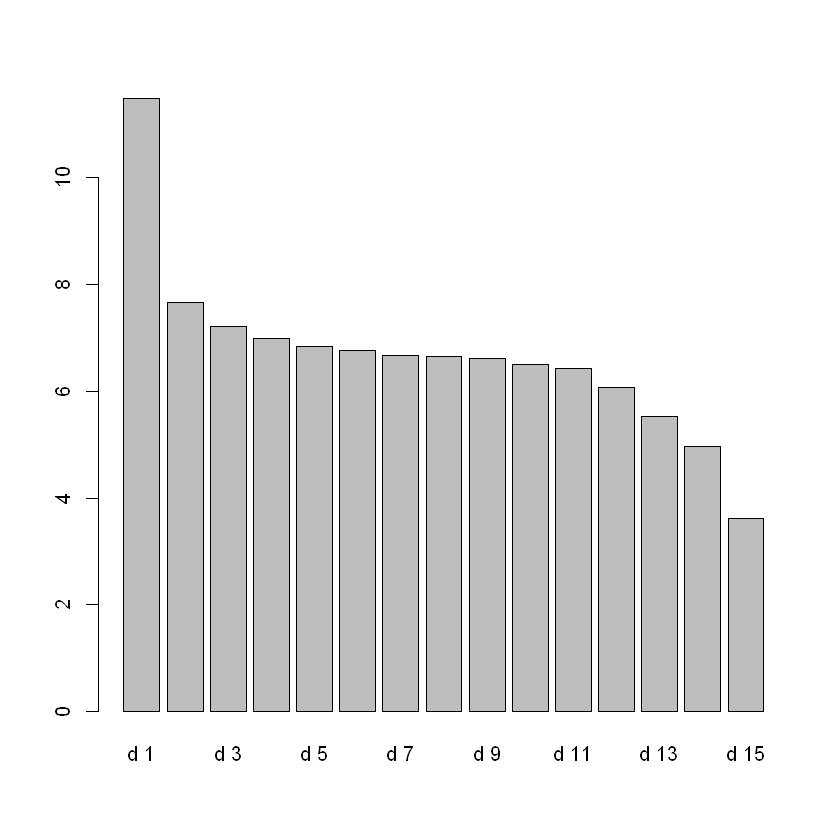

In [5]:
barplot(acm$eig[,2], names=paste("d",1:nrow(acm$eig)))

## 4. MCA variables factor map

First let's plot our acm with the following options
- **cex=0.8** : Size of the points
- **invisible=c("ind","quali.sup","quanti.sup")** : We only want to plot the variables on the graph

Warning message:
"ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


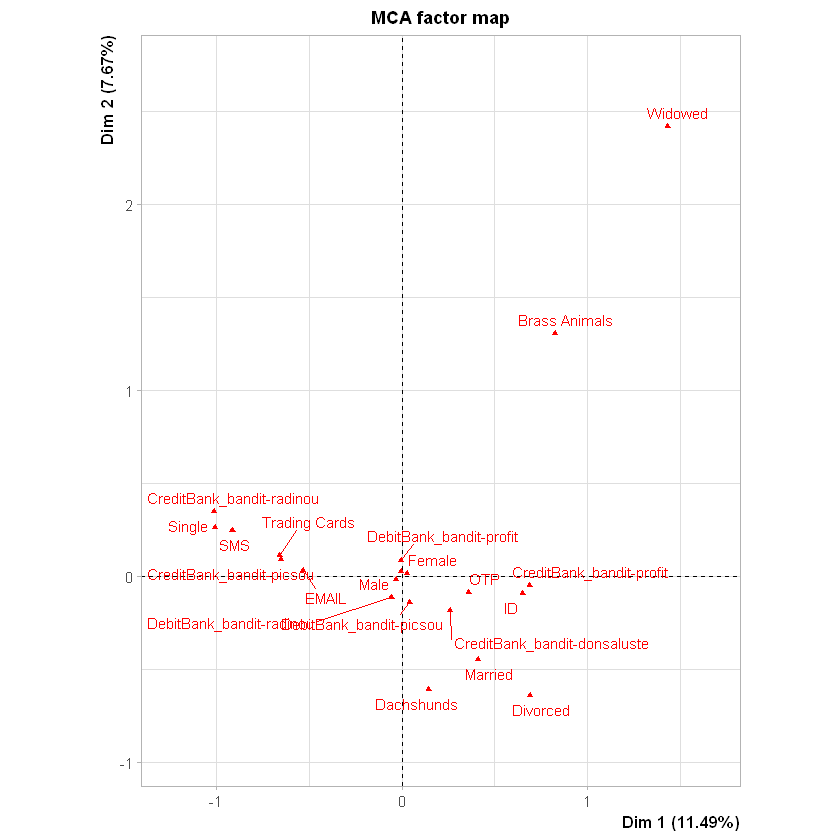

In [6]:
plot(acm, invisible = c("ind", "quali.sup", "quanti.sup"), cex = 0.8)

Based on this graph, it's quite hard to see groups and interpret the relations between
the axes and our variables. In order to see a little bit clearer, we could pass
to the next graph

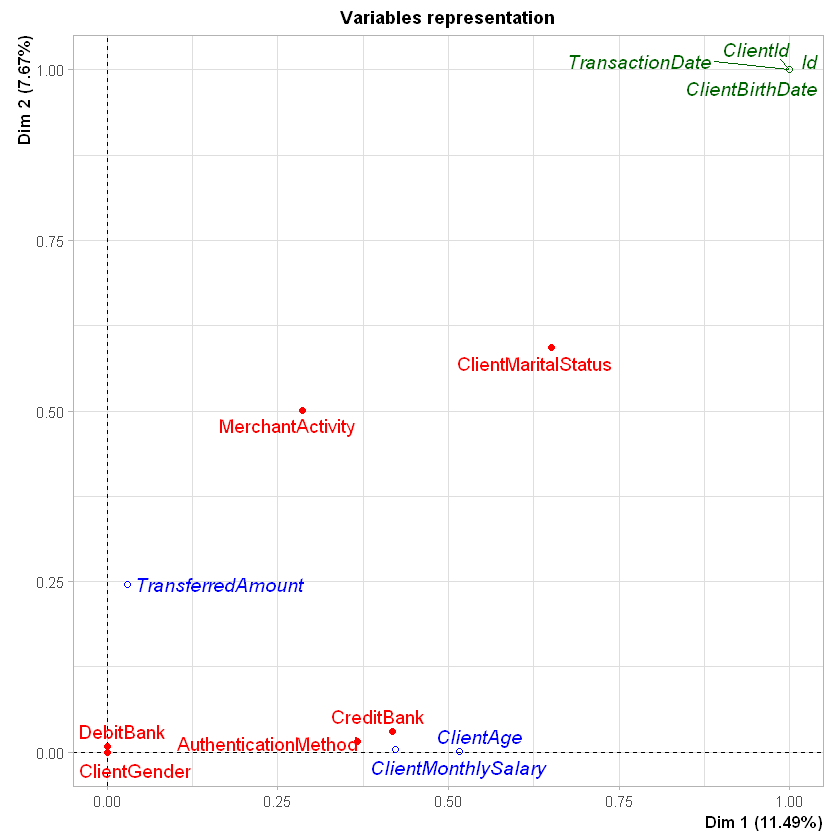

In [15]:
plot(acm, choix="var")

Here, we can't say much for the horizontal axis. By contrast, the vertical axis seems a little bit more interseting
in our case. We can see that it's mainly built from the MerchantActivity and the ClientMaritalStatus

When we inspect the previous graph, we may find that the Brass Animals seems to be related to the Widowed persons.
To further investigate this hypothesis, we could take advantage of the plotellipses function

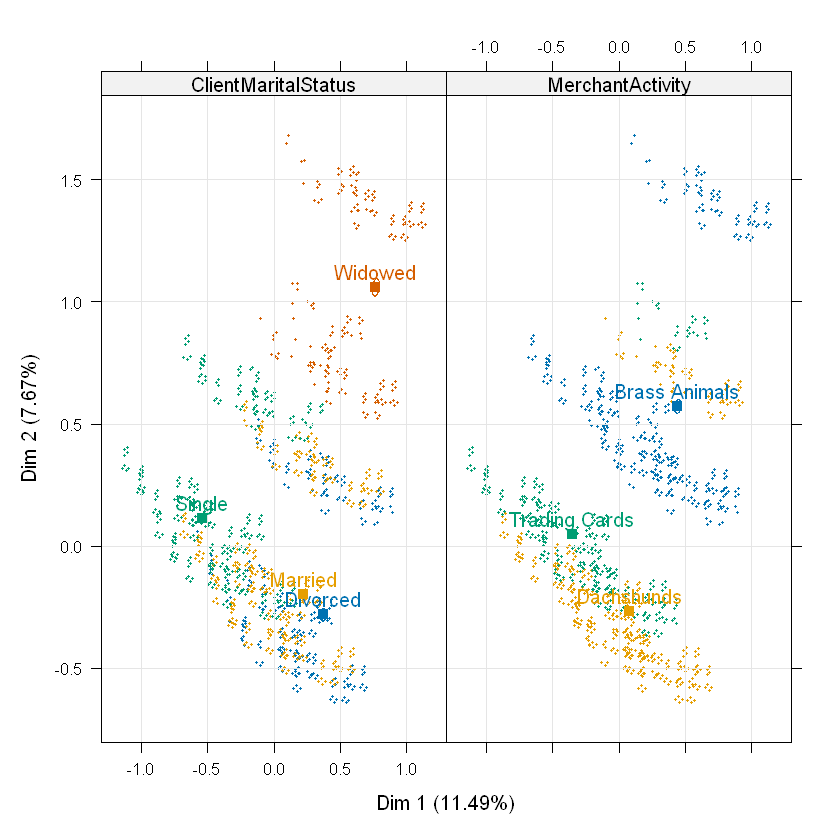

In [16]:
plotellipses(acm, keepvar = c("ClientMaritalStatus","MerchantActivity"), label="none")

More than the Brass Animals only linked to the Widowed persons, we may see that the repartition of
the points seems to indicate a possible correlation between the MaritalStatus and the MerchantActivity

In order to prove this correlation, we could use the CHI-SQUARE method

In [19]:
chisq.test(transactions$ClientMaritalStatus,transactions$MerchantActivity)


	Pearson's Chi-squared test

data:  transactions$ClientMaritalStatus and transactions$MerchantActivity
X-squared = 1170.6, df = 6, p-value < 2.2e-16


Based on the p-value, we can definitely say that there's a correlation between the ClientMaritalStatus and the MerchantActivity

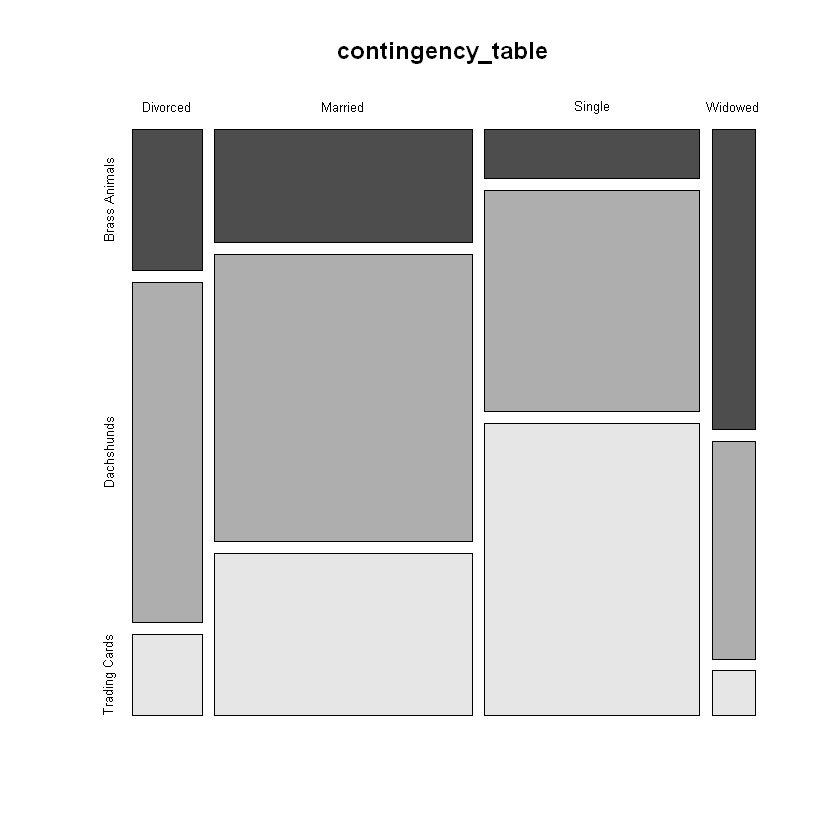

In [23]:
contingency_table <- table(transactions$ClientMaritalStatus, transactions$MerchantActivity)
mosaicplot(contingency_table, color = TRUE)

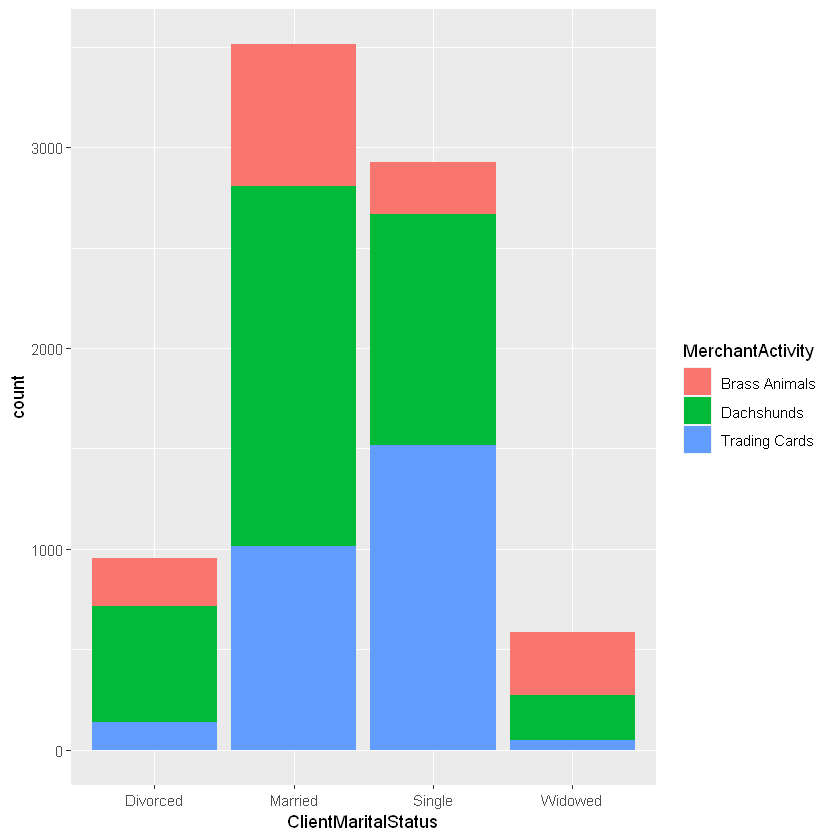

In [26]:
library(ggplot2)

ggplot(transactions, aes(x = ClientMaritalStatus, fill = MerchantActivity)) + geom_bar()

In [13]:
age_groups <- c("<20", "20-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", ">=60")
bounds <- c(0, 20, 24, 29, 34, 39, 44, 49, 54, 59, Inf)
AgeGroup <- unlist(lapply(seq_len(nrow(transactions)), function(i) { cut(transactions$ClientAge[i], breaks = bounds, labels = age_groups) }))
transactions$AgeGroup <- AgeGroup

In [14]:
acm <- MCA(transactions, graph=FALSE, quanti.sup=c("ClientAge","ClientMonthlySalary","TransferredAmount"), quali.sup=c("Id", "ClientId", "ClientBirthDate","TransactionDate"))

In [29]:
acm$eig

,eigenvalue,percentage of variance,cumulative percentage of variance
dim 1,0.34180901,9.969429,9.969429
dim 2,0.19725741,5.753341,15.722771
dim 3,0.17211559,5.020038,20.742809
dim 4,0.16388274,4.779913,25.522722
dim 5,0.15422338,4.498182,30.020904
dim 6,0.15090655,4.401441,34.422345
dim 7,0.14867963,4.336489,38.758834
dim 8,0.14717151,4.292502,43.051337
dim 9,0.14556336,4.245598,47.296935
dim 10,0.14409395,4.202740,51.499675


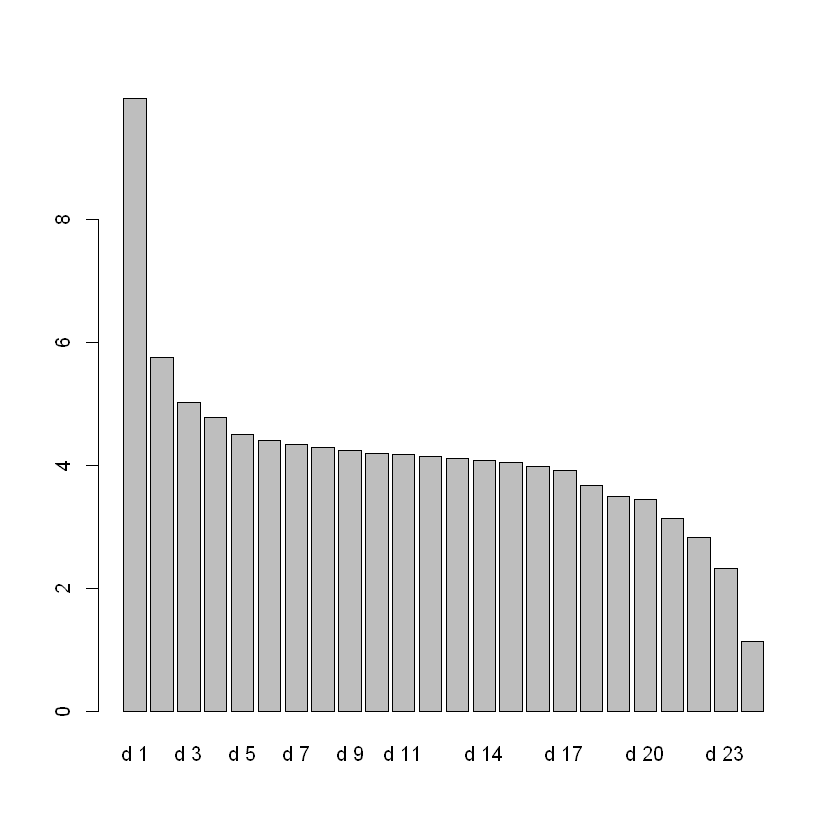

In [30]:
barplot(acm$eig[,2], names=paste("d",1:nrow(acm$eig)))

Warning message:
"ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


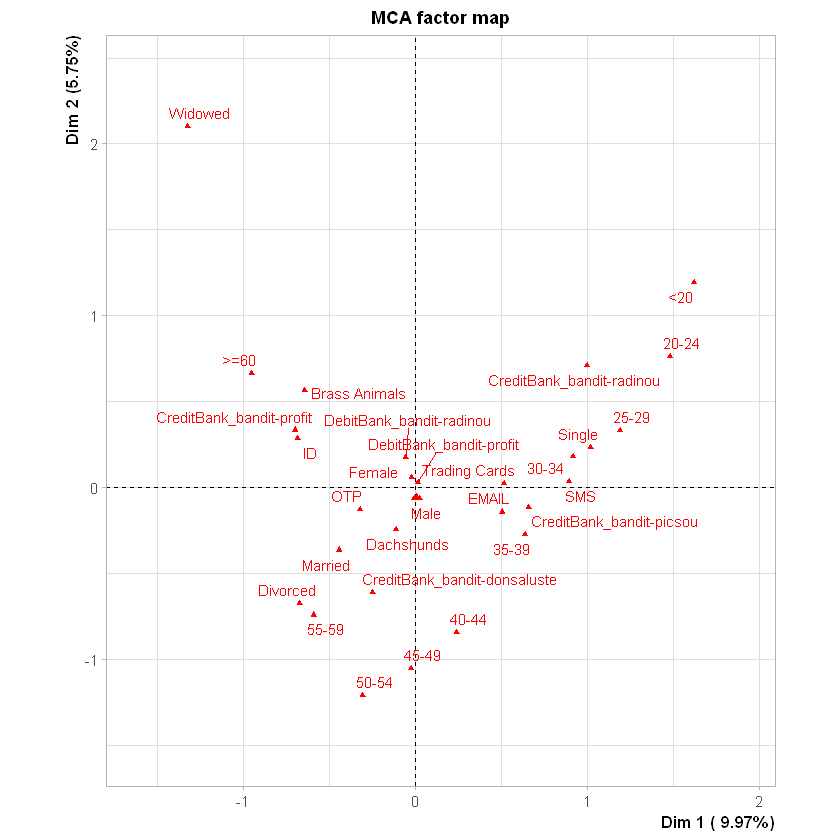

In [23]:
plot(acm, invisible = c("ind", "quali.sup", "quanti.sup"), cex = 0.8)

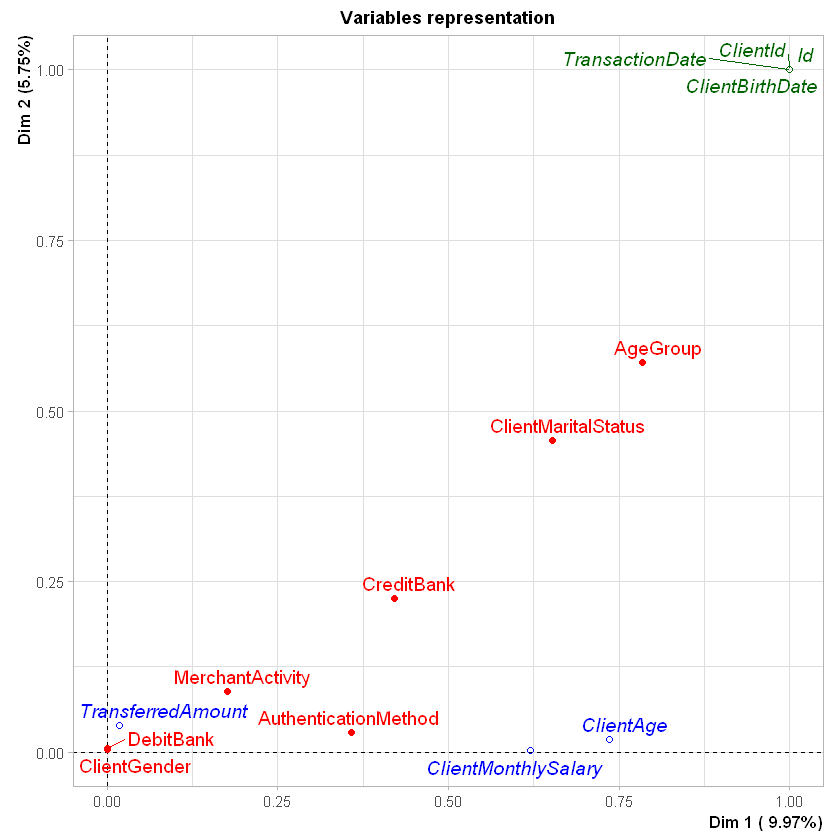

In [16]:
plot(acm, choix="var")

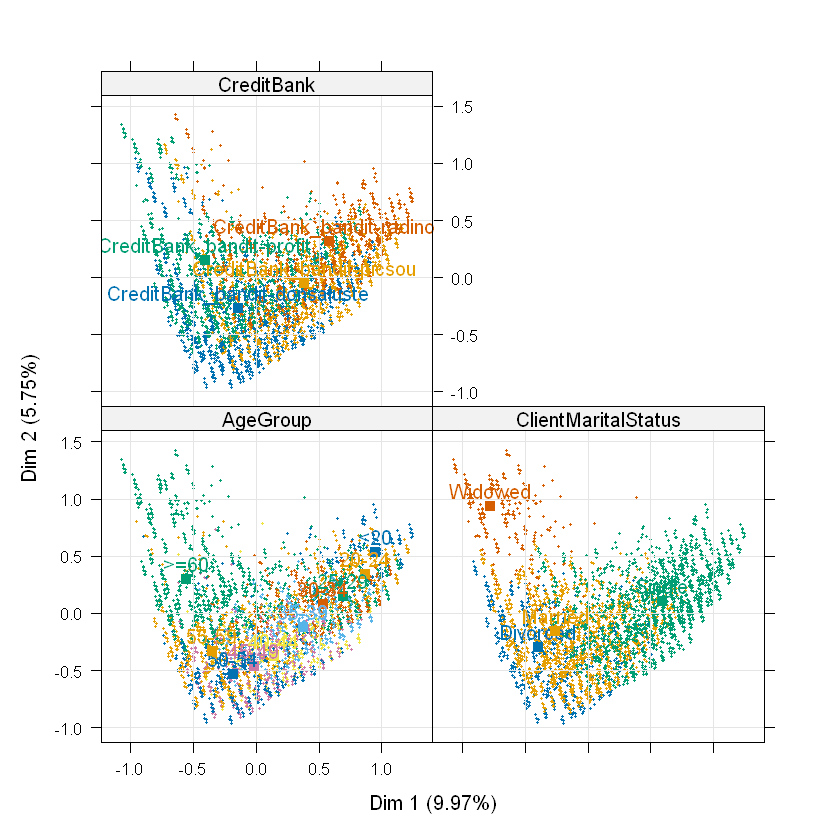

In [24]:
plotellipses(acm, keepvar = c("ClientMaritalStatus","AgeGroup","CreditBank"), label="none")

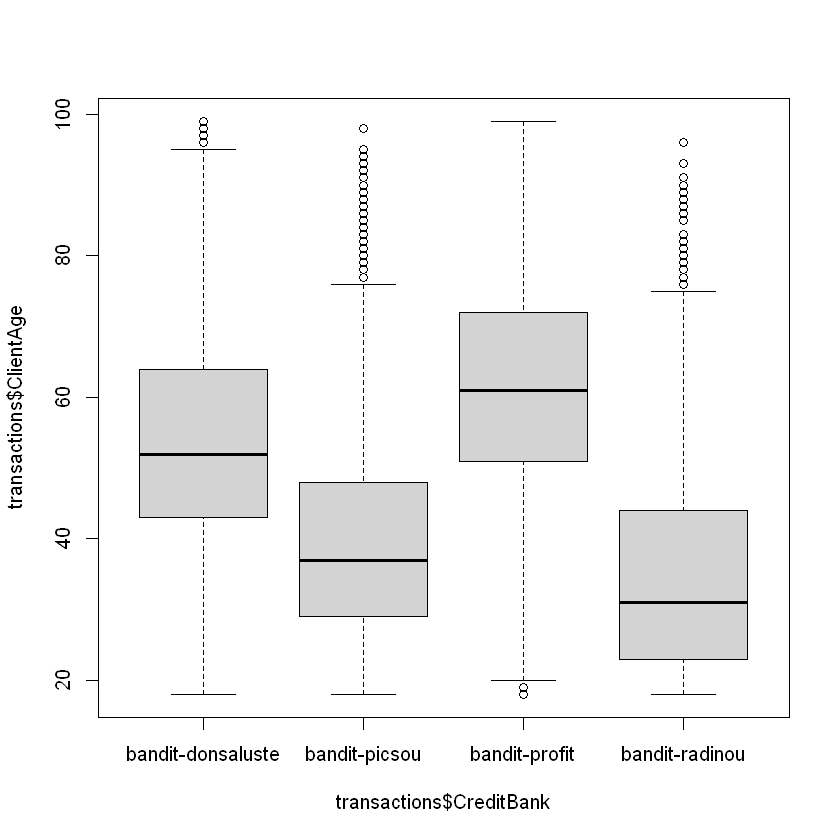

In [25]:
boxplot(transactions$ClientAge~transactions$CreditBank)

In [26]:
model <- lm(transactions$ClientAge~transactions$CreditBank)
anova(model)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
transactions$CreditBank,3,683507.6,227835.8771,833.1015,0
Residuals,7976,2181269.6,273.4791,NA,NA


In [27]:
pairwise.t.test(transactions$ClientAge, transactions$CreditBank, p.adjust.method = "none", pool.sd = T)


	Pairwise comparisons using t tests with pooled SD 

data:  transactions$ClientAge and transactions$CreditBank 

               bandit-donsaluste bandit-picsou bandit-profit
bandit-picsou  < 2e-16           -             -            
bandit-profit  < 2e-16           < 2e-16       -            
bandit-radinou < 2e-16           5.6e-11       < 2e-16      

P value adjustment method: none 


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




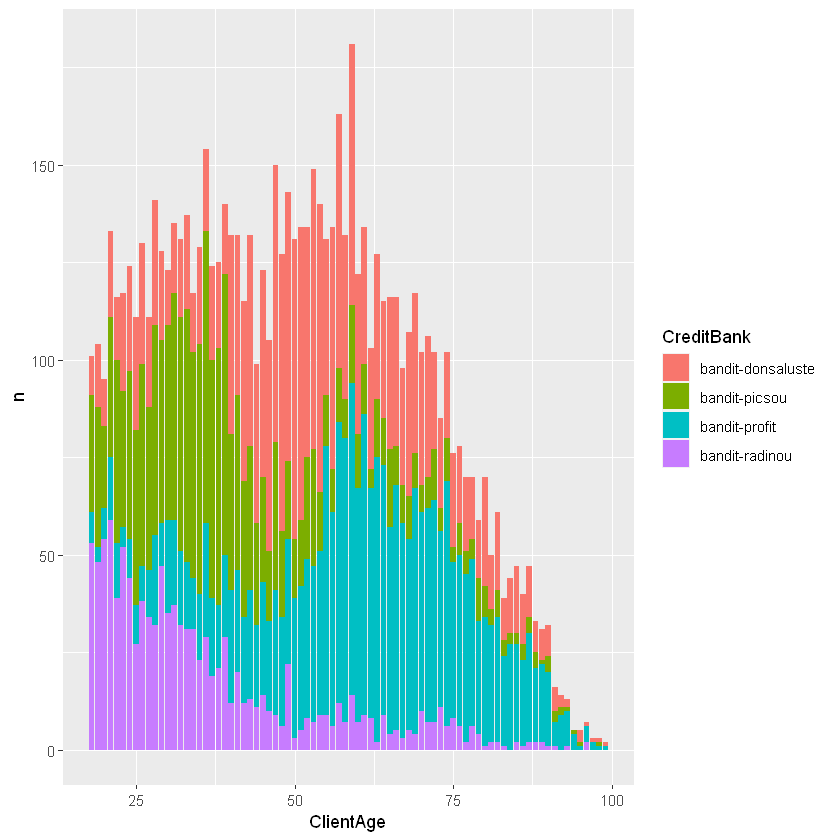

In [28]:
library(ggplot2)
library(dplyr)
counts <- transactions %>% count(ClientAge, CreditBank)
ggplot(counts, aes(x = ClientAge, y = n, fill = CreditBank)) + geom_col()